📌 Shape: (10000, 11)
📌 Columns: ['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']
📌 Data Types:
 CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object
📌 Missing Values:
 CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64
📌 Target Distribution:
 Exited
0    79.63
1    20.37
Name: proportion, dtype: float64


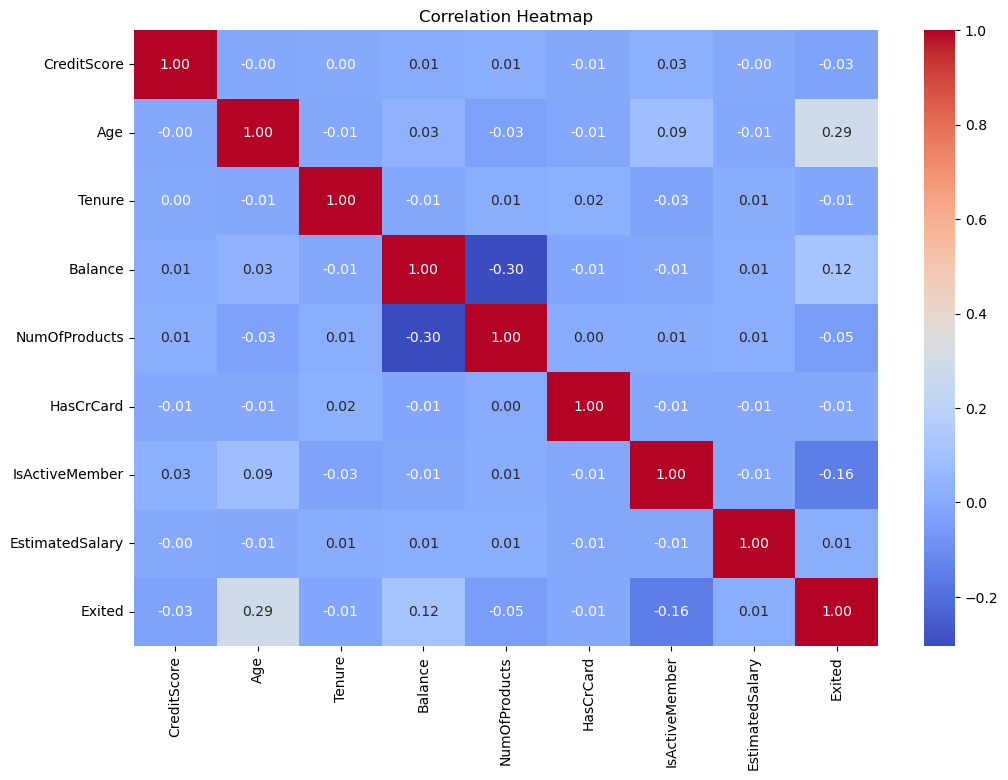

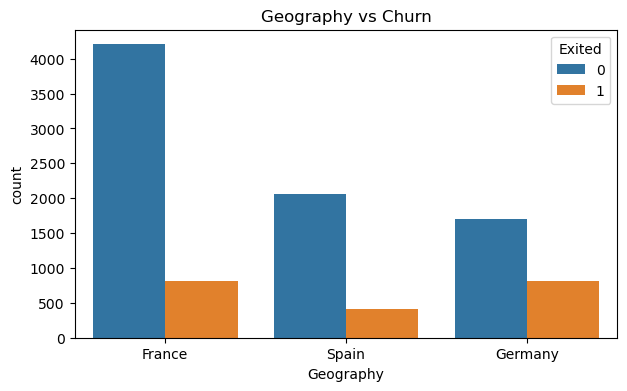

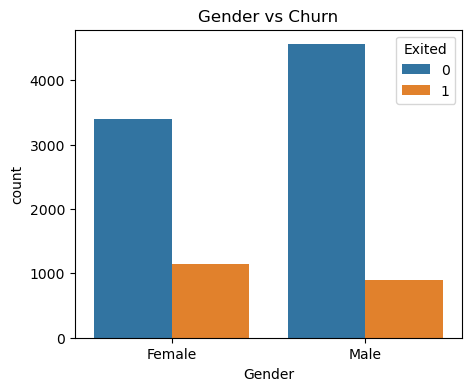

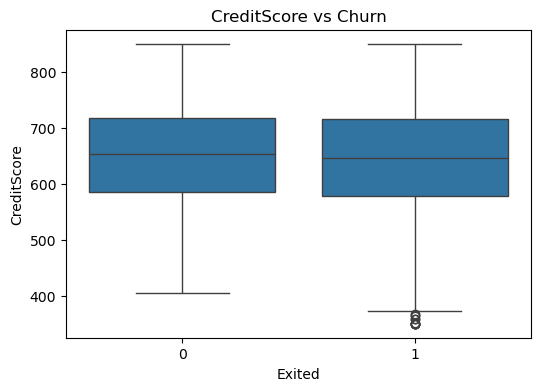

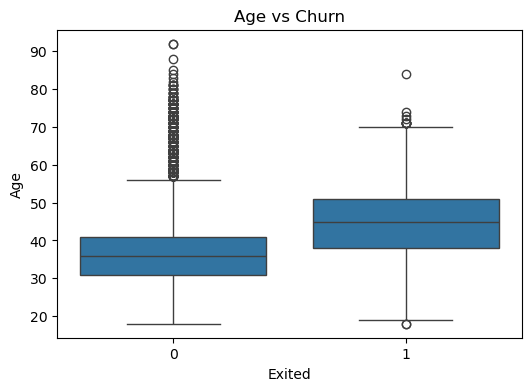

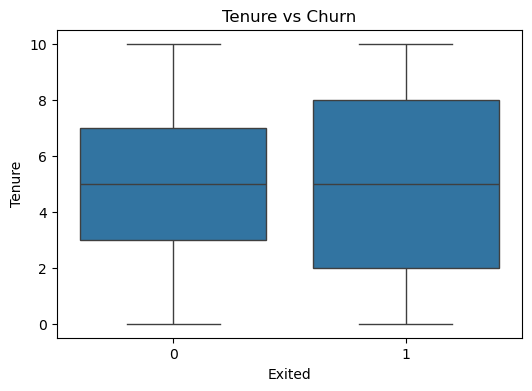

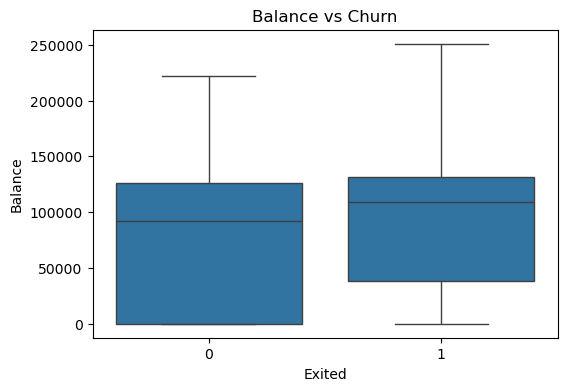

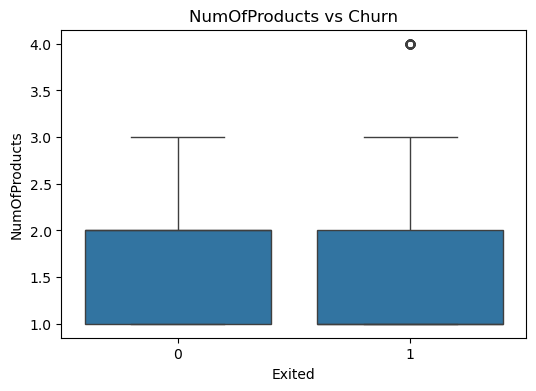

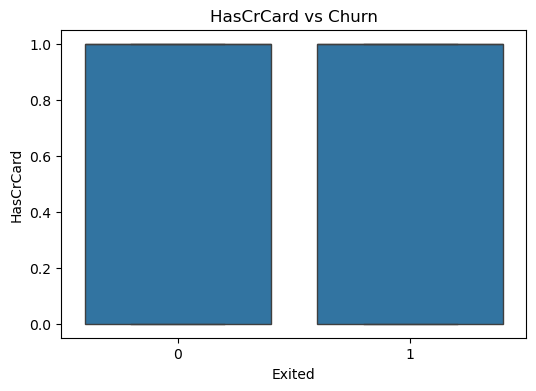

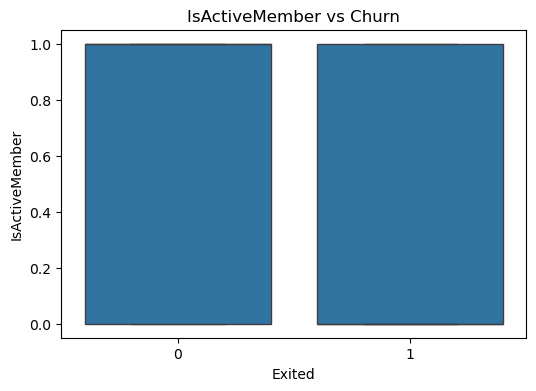

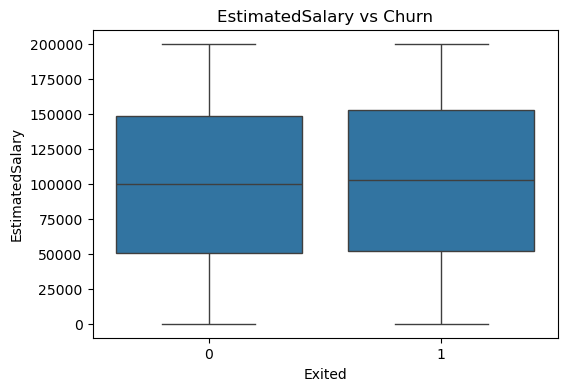

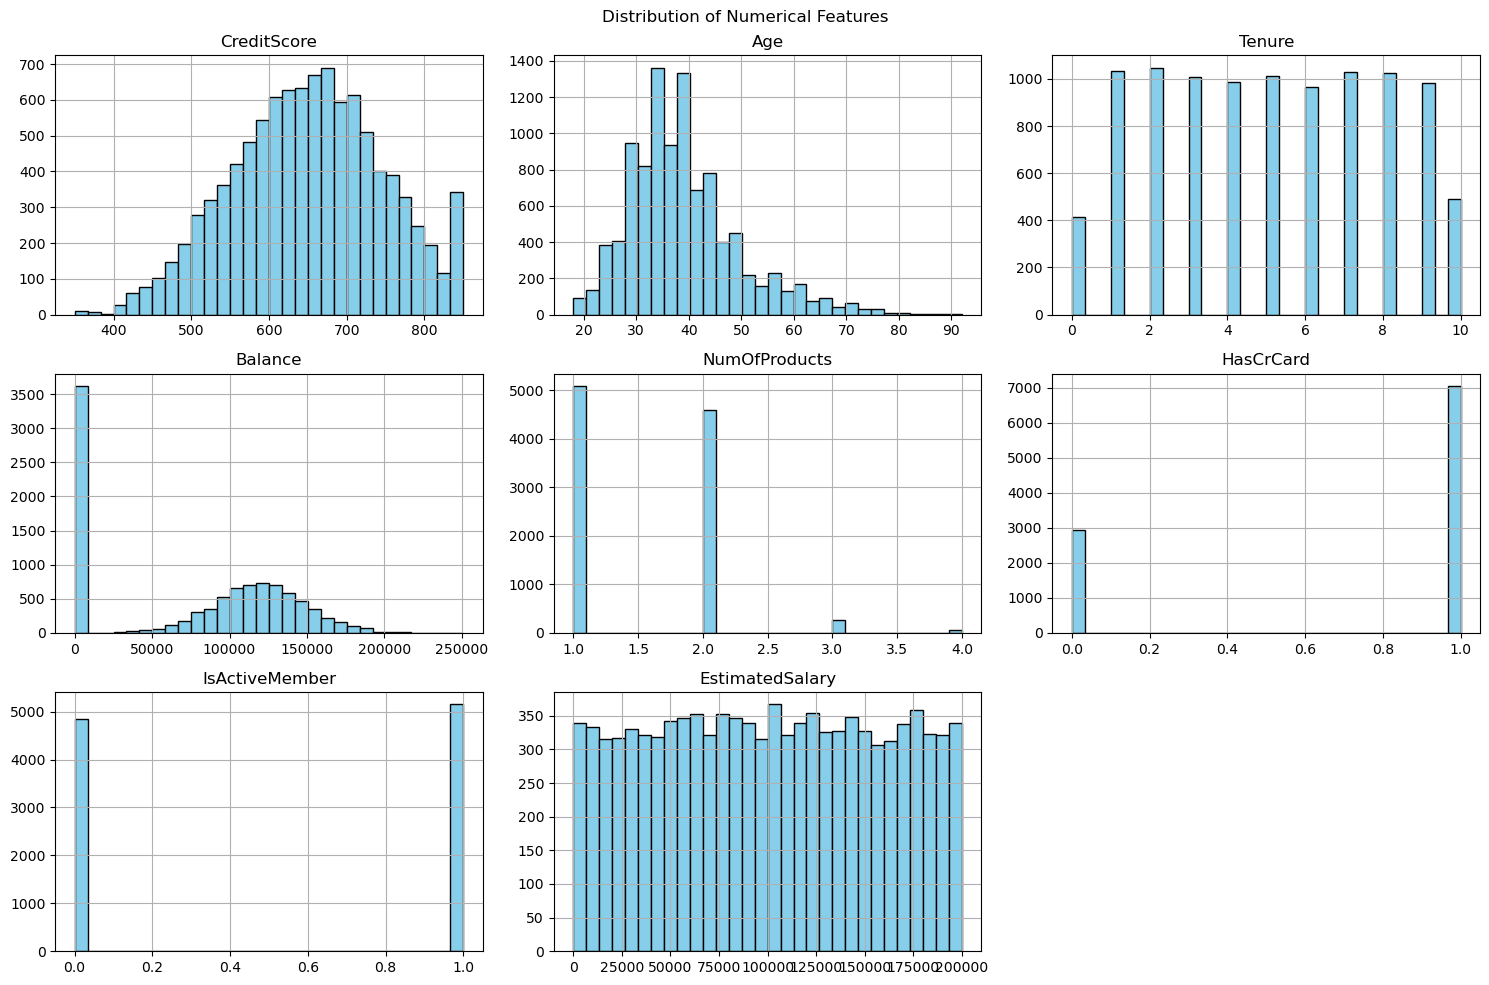

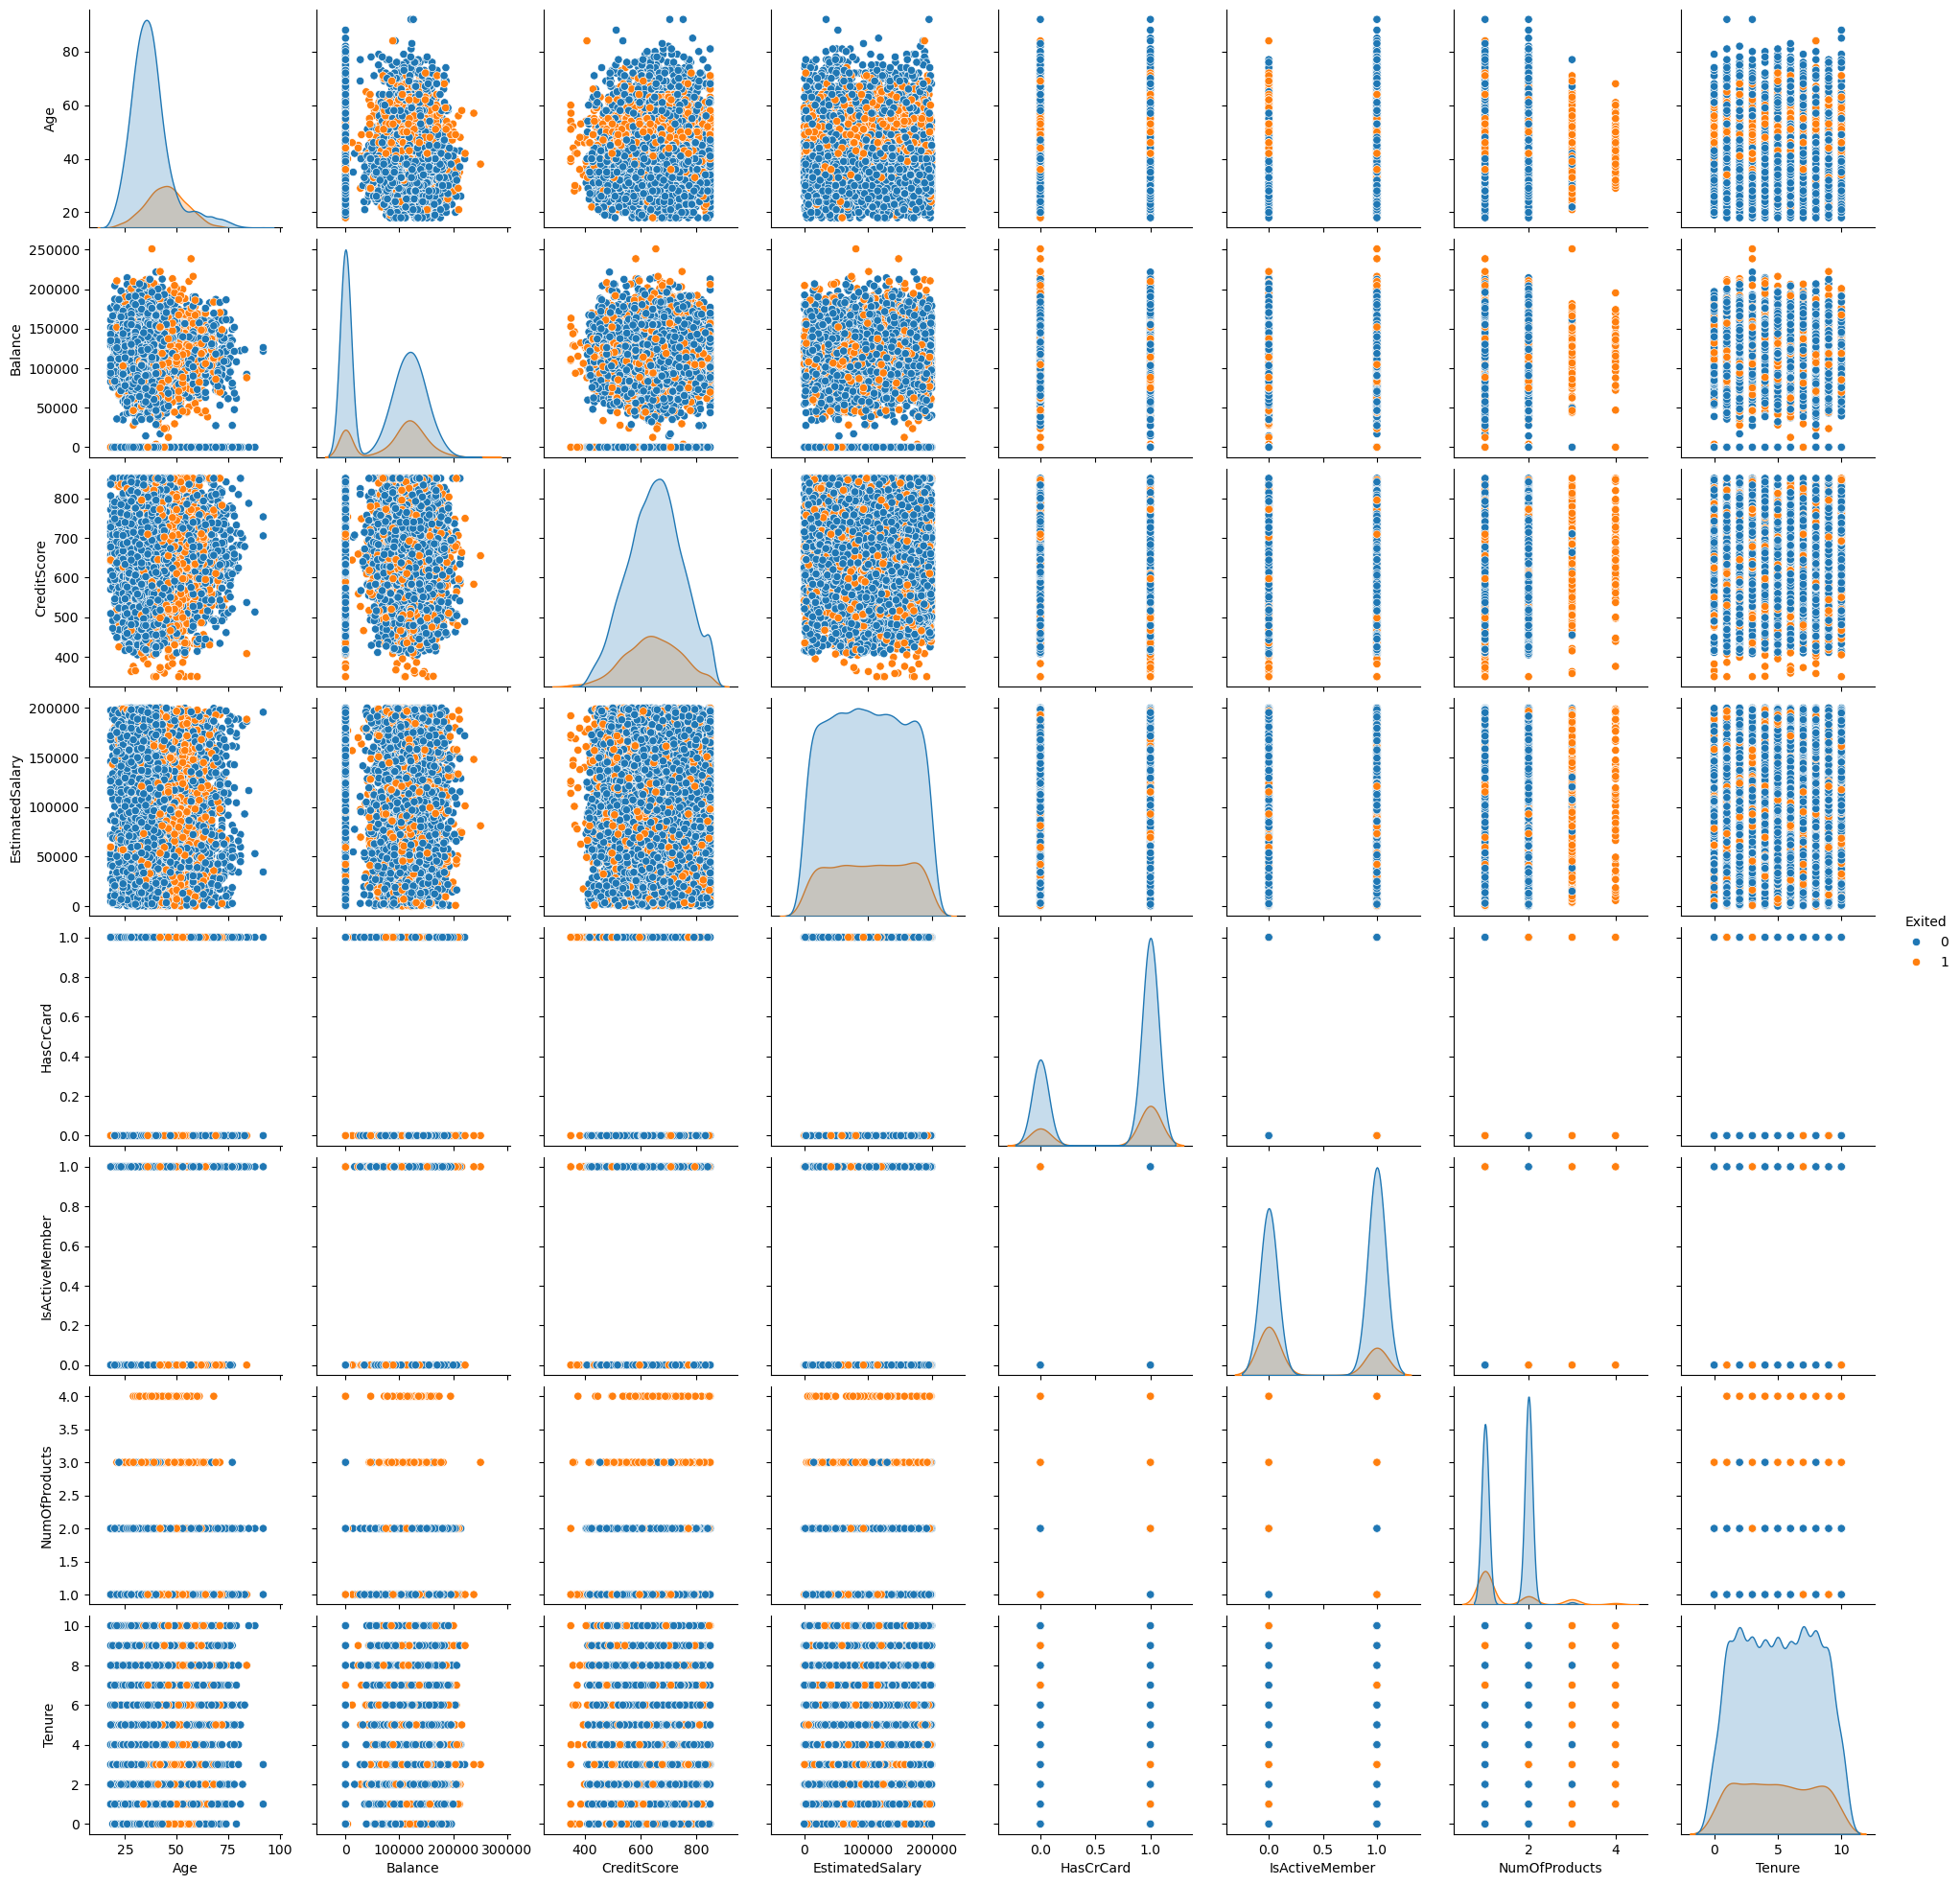

In [8]:
#eda
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.chdir("/Users/muskansohaney/Downloads")
data = pd.read_csv("Churn_Modelling.csv")

data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

print("📌 Shape:", data.shape)
print("📌 Columns:", data.columns.tolist())
print("📌 Data Types:\n", data.dtypes)
print("📌 Missing Values:\n", data.isnull().sum())
print("📌 Target Distribution:\n", data['Exited'].value_counts(normalize=True) * 100)

corr = data.corr(numeric_only=True)
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

plt.figure(figsize=(7, 4))
sns.countplot(x='Geography', hue='Exited', data=data)
plt.title("Geography vs Churn")
plt.show()

plt.figure(figsize=(5, 4))
sns.countplot(x='Gender', hue='Exited', data=data)
plt.title("Gender vs Churn")
plt.show()

numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns.drop('Exited')
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='Exited', y=col, data=data)
    plt.title(f'{col} vs Churn')
    plt.show()

data[numerical_cols].hist(bins=30, figsize=(15, 10), color='skyblue', edgecolor='black')
plt.suptitle('Distribution of Numerical Features')
plt.tight_layout()
plt.show()


sns.pairplot(data[numerical_cols.union(['Exited'])], hue='Exited')
plt.show()


In [9]:
#rf model
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

os.chdir("/Users/muskansohaney/Downloads")

data = pd.read_csv("Churn_Modelling.csv")
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
data['Gender'] = LabelEncoder().fit_transform(data['Gender'])
data = pd.get_dummies(data, columns=['Geography'], drop_first=True)

X = data.drop('Exited', axis=1)
y = data['Exited']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_probs_o = rf_model.predict_proba(X_test)[:, 1]  # Probability of churn

print("\nRandom Forest Probabilities (first 10):")
print(np.round(rf_probs_o[:10], 3))

rf_preds = (rf_probs_o >= 0.5).astype(int)
print("\nRandom Forest (Threshold = 0.5):")
print(confusion_matrix(y_test, rf_preds))
print(classification_report(y_test, rf_preds))
print("AUC Score:", roc_auc_score(y_test, rf_probs_o))
#--------------rf model with feature selection--------------#

full_rf = RandomForestClassifier(n_estimators=100, random_state=42)
full_rf.fit(X_train, y_train)

importances = full_rf.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# ---------- Step 2: Pick Top 5 Features ----------
top10_features = feature_importance_df.head(10)['Feature'].tolist()
print("🔥 Top 10 Important Features:", top10_features)

# ---------- Step 3: Train new RF using Top 5 Features ----------
rf_top10 = RandomForestClassifier(n_estimators=100, random_state=42)
rf_top10.fit(X_train[top10_features], y_train)

# ---------- Step 4: Evaluate ----------
rf_probs = rf_top10.predict_proba(X_test[top10_features])[:, 1]
rf_preds = (rf_probs >= 0.5).astype(int)

print("\n📊 RF Model (Top 5 Features):")
print(confusion_matrix(y_test, rf_preds))
print(classification_report(y_test, rf_preds))
print("AUC Score:", roc_auc_score(y_test, rf_probs))


Random Forest Probabilities (first 10):
[0.04 0.08 0.19 0.14 0.06 0.   0.13 0.27 0.39 0.3 ]

Random Forest (Threshold = 0.5):
[[1546   61]
 [ 207  186]]
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1607
           1       0.75      0.47      0.58       393

    accuracy                           0.87      2000
   macro avg       0.82      0.72      0.75      2000
weighted avg       0.86      0.87      0.85      2000

AUC Score: 0.8560290459519501
🔥 Top 10 Important Features: ['Age', 'EstimatedSalary', 'CreditScore', 'Balance', 'NumOfProducts', 'Tenure', 'IsActiveMember', 'Geography_Germany', 'Gender', 'HasCrCard']

📊 RF Model (Top 5 Features):
[[1540   67]
 [ 200  193]]
              precision    recall  f1-score   support

           0       0.89      0.96      0.92      1607
           1       0.74      0.49      0.59       393

    accuracy                           0.87      2000
   macro avg       0.81      0.72      0.76

In [12]:
print("Old AUC:", roc_auc_score(y_test, rf_probs_o))
print("New AUC:", roc_auc_score(y_test, rf_probs))

Old AUC: 0.8560290459519501
New AUC: 0.8592259374143972


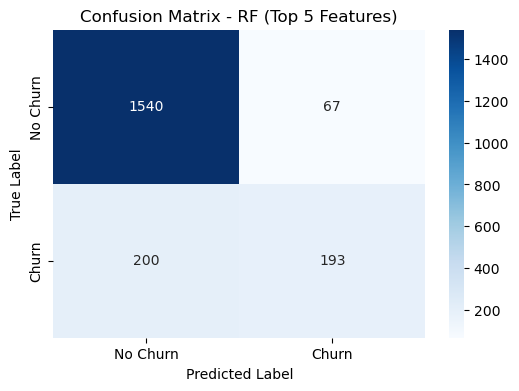

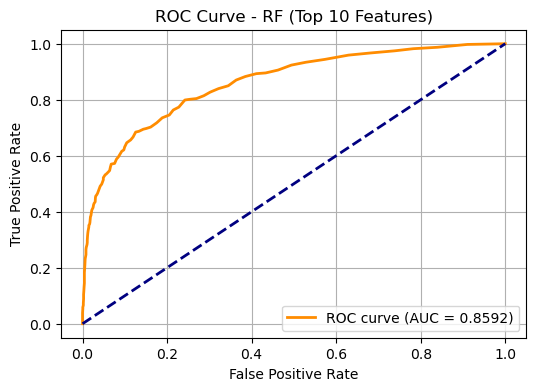

/var/folders/gx/_4cd6swx79v2tblf348jttlw0000gn/T/ipykernel_83065/3151572712.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top10_importances, y=top10_features, palette="viridis")


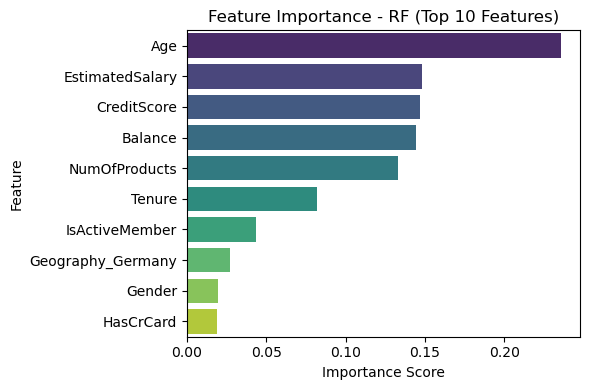

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, ConfusionMatrixDisplay
plt.figure(figsize=(6, 4))
cm = confusion_matrix(y_test, rf_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No Churn", "Churn"], yticklabels=["No Churn", "Churn"])
plt.title("Confusion Matrix - RF (Top 5 Features)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, rf_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - RF (Top 10 Features)")
plt.legend(loc="lower right")
plt.grid()
plt.show()

plt.figure(figsize=(6, 4))
top10_importances = rf_top10.feature_importances_
sns.barplot(x=top10_importances, y=top10_features, palette="viridis")
plt.title("Feature Importance - RF (Top 10 Features)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

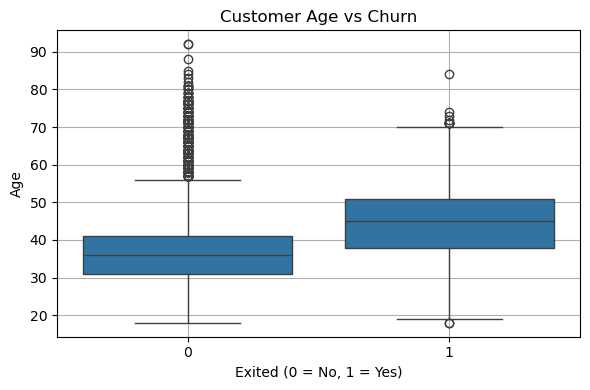

/var/folders/gx/_4cd6swx79v2tblf348jttlw0000gn/T/ipykernel_83065/2199484596.py:19: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['Exited'] == 0]['Age'], label='Not Churned', shade=True, color='green')
/var/folders/gx/_4cd6swx79v2tblf348jttlw0000gn/T/ipykernel_83065/2199484596.py:20: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['Exited'] == 1]['Age'], label='Churned', shade=True, color='red')


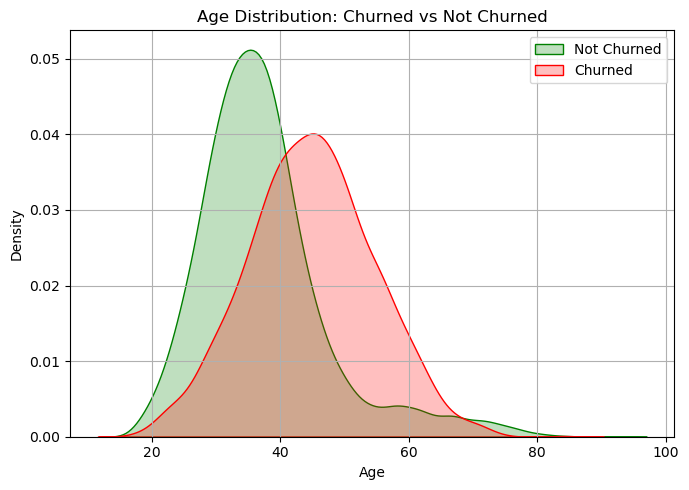

/var/folders/gx/_4cd6swx79v2tblf348jttlw0000gn/T/ipykernel_83065/2199484596.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_by_age = df.groupby('AgeGroup')['Exited'].mean().reset_index()
/var/folders/gx/_4cd6swx79v2tblf348jttlw0000gn/T/ipykernel_83065/2199484596.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=churn_by_age, x='AgeGroup', y='Exited', palette='coolwarm')


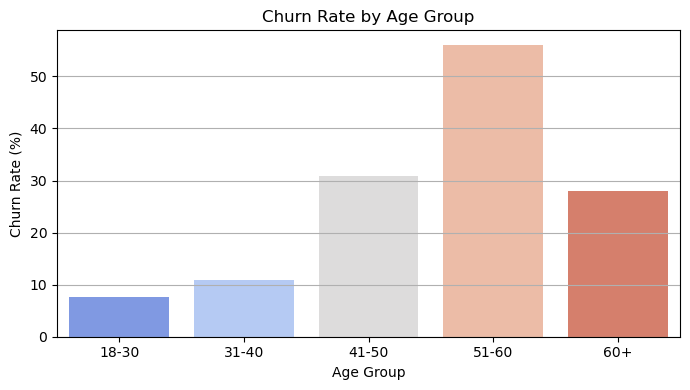

In [16]:
#age vs churn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("Churn_Modelling.csv")
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

plt.figure(figsize=(6, 4))
sns.boxplot(x='Exited', y='Age', data=df)
plt.title("Customer Age vs Churn")
plt.xlabel("Exited (0 = No, 1 = Yes)")
plt.ylabel("Age")
plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 5))
sns.kdeplot(df[df['Exited'] == 0]['Age'], label='Not Churned', shade=True, color='green')
sns.kdeplot(df[df['Exited'] == 1]['Age'], label='Churned', shade=True, color='red')
plt.title("Age Distribution: Churned vs Not Churned")
plt.xlabel("Age")
plt.ylabel("Density")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

bins = [18, 30, 40, 50, 60, 100]
labels = ['18-30', '31-40', '41-50', '51-60', '60+']
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

churn_by_age = df.groupby('AgeGroup')['Exited'].mean().reset_index()
churn_by_age['Exited'] *= 100  # Convert to percentage

plt.figure(figsize=(7, 4))
sns.barplot(data=churn_by_age, x='AgeGroup', y='Exited', palette='coolwarm')
plt.title("Churn Rate by Age Group")
plt.ylabel("Churn Rate (%)")
plt.xlabel("Age Group")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


/var/folders/gx/_4cd6swx79v2tblf348jttlw0000gn/T/ipykernel_83065/1376642460.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Exited', y='EstimatedSalary', data=df, palette='Set2')


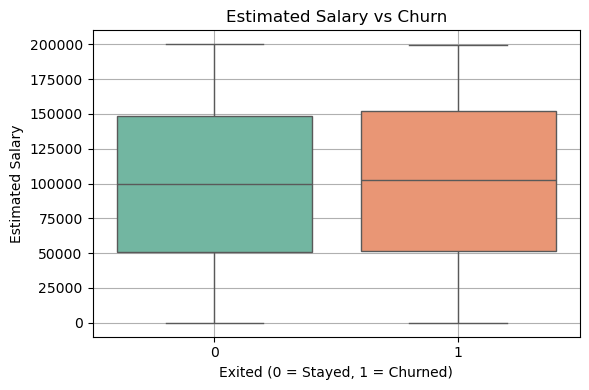

/var/folders/gx/_4cd6swx79v2tblf348jttlw0000gn/T/ipykernel_83065/1376642460.py:18: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['Exited'] == 0]['EstimatedSalary'], label='Not Churned', shade=True, color='green')
/var/folders/gx/_4cd6swx79v2tblf348jttlw0000gn/T/ipykernel_83065/1376642460.py:19: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['Exited'] == 1]['EstimatedSalary'], label='Churned', shade=True, color='red')


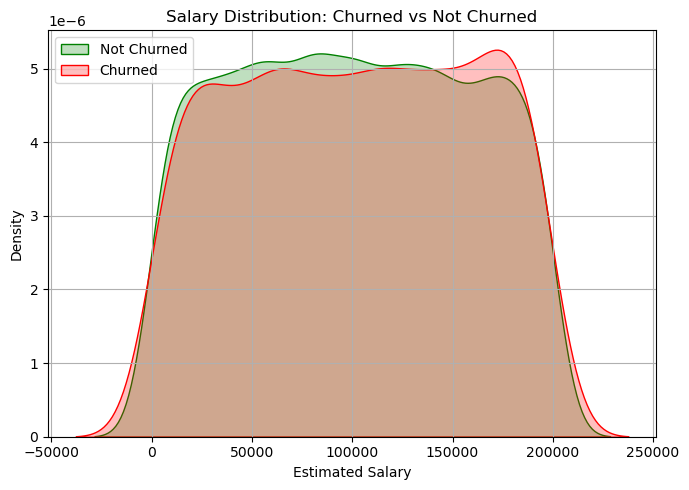

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("Churn_Modelling.csv")
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

plt.figure(figsize=(6, 4))
sns.boxplot(x='Exited', y='EstimatedSalary', data=df, palette='Set2')
plt.title("Estimated Salary vs Churn")
plt.xlabel("Exited (0 = Stayed, 1 = Churned)")
plt.ylabel("Estimated Salary")
plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 5))
sns.kdeplot(df[df['Exited'] == 0]['EstimatedSalary'], label='Not Churned', shade=True, color='green')
sns.kdeplot(df[df['Exited'] == 1]['EstimatedSalary'], label='Churned', shade=True, color='red')
plt.title("Salary Distribution: Churned vs Not Churned")
plt.xlabel("Estimated Salary")
plt.ylabel("Density")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


/var/folders/gx/_4cd6swx79v2tblf348jttlw0000gn/T/ipykernel_14178/4092077393.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=churn_by_activity, x='IsActiveMember', y='Exited', palette='coolwarm')


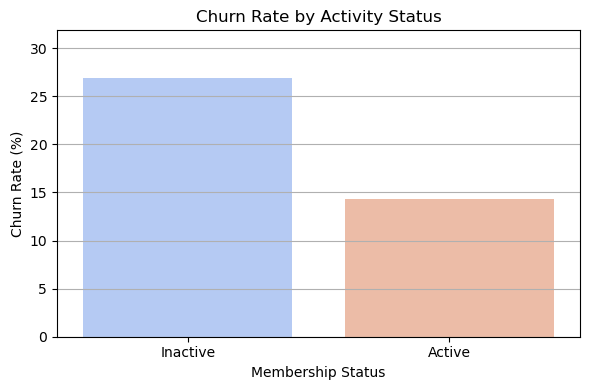

In [7]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
os.chdir("/Users/muskansohaney/Downloads")
df = pd.read_csv("Churn_Modelling.csv")

churn_by_activity = df.groupby('IsActiveMember')['Exited'].mean().reset_index()
churn_by_activity['Exited'] *= 100  # convert to percentage
churn_by_activity['IsActiveMember'] = churn_by_activity['IsActiveMember'].map({0: 'Inactive', 1: 'Active'})

plt.figure(figsize=(6, 4))
sns.barplot(data=churn_by_activity, x='IsActiveMember', y='Exited', palette='coolwarm')
plt.title("Churn Rate by Activity Status")
plt.xlabel("Membership Status")
plt.ylabel("Churn Rate (%)")
plt.ylim(0, churn_by_activity['Exited'].max() + 5)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

/var/folders/gx/_4cd6swx79v2tblf348jttlw0000gn/T/ipykernel_83065/3628453815.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=churn_by_products, x='NumOfProducts', y='Exited', palette='rocket')


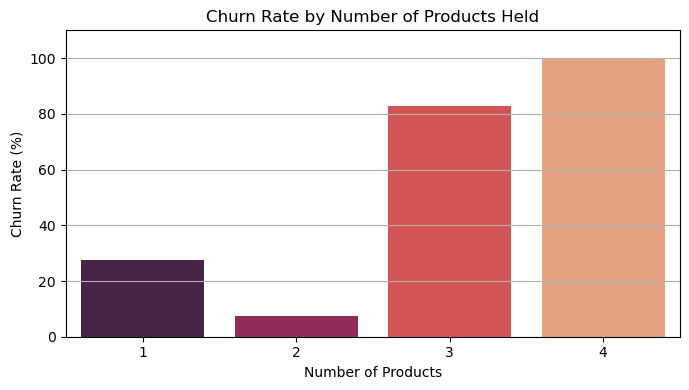

/var/folders/gx/_4cd6swx79v2tblf348jttlw0000gn/T/ipykernel_83065/3628453815.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  salary_churn = df.groupby('SalaryGroup')['Exited'].mean() * 100


In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.read_csv("Churn_Modelling.csv")
churn_by_products = df.groupby('NumOfProducts')['Exited'].mean().reset_index()
churn_by_products['Exited'] *= 100
plt.figure(figsize=(7, 4))
sns.barplot(data=churn_by_products, x='NumOfProducts', y='Exited', palette='rocket')
plt.title("Churn Rate by Number of Products Held")
plt.xlabel("Number of Products")
plt.ylabel("Churn Rate (%)")
plt.ylim(0, 110)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

df['SalaryGroup'] = pd.qcut(df['EstimatedSalary'], 4, labels=["Q1", "Q2", "Q3", "Q4"])
salary_churn = df.groupby('SalaryGroup')['Exited'].mean() * 100


Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB
None 

Summary Statistics:
        CreditScore           Age        Tenure        Balance  NumOfProducts  \
count  10000.000000  10000.000000  10000.000000   10000.000000   10000.000000   
mean     650.528800     38.92

/var/folders/gx/_4cd6swx79v2tblf348jttlw0000gn/T/ipykernel_83065/14450825.py:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agegroup_churn = df.groupby('AgeGroup')['Exited'].mean() * 100
/var/folders/gx/_4cd6swx79v2tblf348jttlw0000gn/T/ipykernel_83065/14450825.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  salary_churn = df.groupby('SalaryGroup')['Exited'].mean() * 100


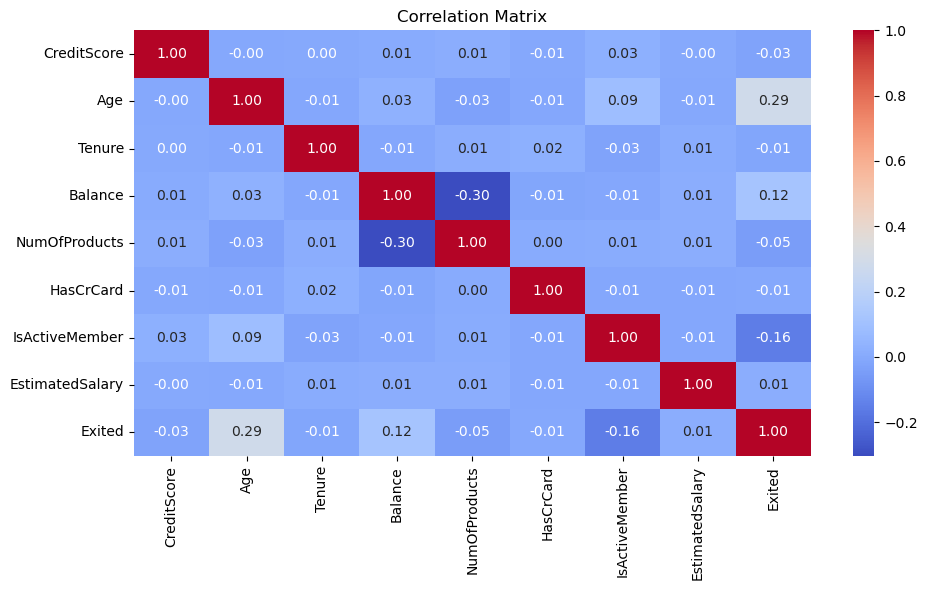

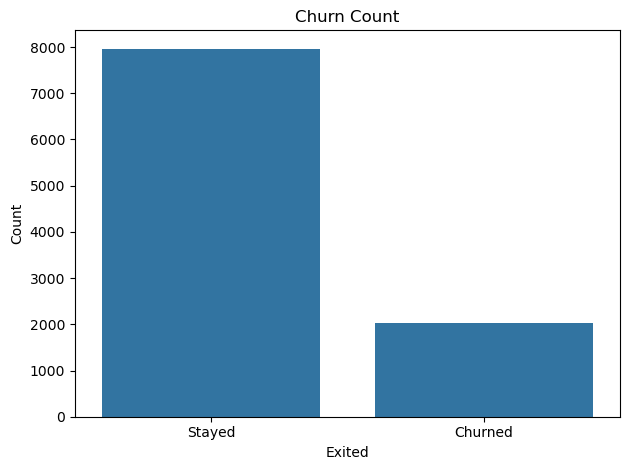

In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("Churn_Modelling.csv")

df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

print("Basic Info:")
print(df.info(), "\n")

print("Summary Statistics:")
print(df.describe(), "\n")

print("Missing Values:")
print(df.isnull().sum(), "\n")

churn_rate = df['Exited'].mean() * 100
print(f"Overall Churn Rate: {churn_rate:.2f}%\n")

gender_churn = df.groupby('Gender')['Exited'].mean() * 100
print("Churn Rate by Gender:")
print(gender_churn, "\n")

geo_churn = df.groupby('Geography')['Exited'].mean() * 100
print("Churn Rate by Geography:")
print(geo_churn, "\n")

activity_churn = df.groupby('IsActiveMember')['Exited'].mean() * 100
print("Churn Rate by Activity:")
print(activity_churn.map({0: 'Inactive', 1: 'Active'}), "\n")

product_churn = df.groupby('NumOfProducts')['Exited'].mean() * 100
print("Churn Rate by Number of Products:")
print(product_churn, "\n")

bins = [18, 30, 40, 50, 60, 100]
labels = ['18–30', '31–40', '41–50', '51–60', '60+']
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)
agegroup_churn = df.groupby('AgeGroup')['Exited'].mean() * 100
print("Churn Rate by Age Group:")
print(agegroup_churn, "\n")

df['SalaryGroup'] = pd.qcut(df['EstimatedSalary'], 4, labels=["Q1", "Q2", "Q3", "Q4"])
salary_churn = df.groupby('SalaryGroup')['Exited'].mean() * 100
print("Churn Rate by Salary Quartile:")
print(salary_churn, "\n")

plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

sns.countplot(data=df, x='Exited')
plt.title("Churn Count")
plt.xticks([0, 1], ['Stayed', 'Churned'])
plt.ylabel("Count")
plt.tight_layout()
plt.show()
